In [5]:
!pip install datasets==3.0.2 faiss-gpu numpy==1.25.0 torch==2.0.0 transformers==4.45.2 sentence_transformers

In [6]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer
import torch
import faiss
import numpy as np

In [7]:
# Załadowanie zbioru danych SQuAD z HuggingFace
dataset = load_dataset("sentence-transformers/squad")
dataset

train-00000-of-00001.parquet:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87599
    })
})

In [8]:
dataset["train"]

Dataset({
    features: ['question', 'answer'],
    num_rows: 87599
})

In [9]:
# Usunięcie duplikatów z kolumny 'question'
unique_questions = list(set(dataset["train"]["question"]))

# Usunięcie duplikatów z kolumny 'answer'
unique_answers = list(set(dataset["train"]["answer"]))

len(unique_questions), len(unique_answers)

(87341, 18891)

In [10]:
model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
device = torch.device("cuda")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [12]:
# Tworzenie osadzeń dla kolumny 'answer' (dokumenty)
# Osadzenia będą używane do porównywania z zapytaniami
answer_embeddings = model.encode(
    unique_answers, batch_size=32, convert_to_tensor=True, show_progress_bar=True
)

Batches:   0%|          | 0/591 [00:00<?, ?it/s]

In [13]:
# Tworzenie osadzeń dla kolumny 'question' (zapytania)
question_embeddings = model.encode(
    unique_questions, batch_size=32, convert_to_tensor=True, show_progress_bar=True
)

Batches:   0%|          | 0/2730 [00:00<?, ?it/s]

In [14]:
question_embeddings = question_embeddings.to("cuda")
answer_embeddings = answer_embeddings.to("cuda")

In [15]:
question_embeddings = util.normalize_embeddings(question_embeddings)
answer_embeddings = util.normalize_embeddings(answer_embeddings)

In [ ]:
# zapisz do pickle
# import pickle
#
# with open("question_embeddings.pkl", "wb") as f:
#    pickle.dump(question_embeddings, f)
#
# with open("answer_embeddings.pkl", "wb") as f:
#    pickle.dump(answer_embeddings, f)
#
# with open("model.pkl", "wb") as f:
#    pickle.dump(model, f)

In [16]:
# załaduj pickle
import pickle

with open("question_embeddings.pkl", "rb") as f:
    question_embeddings = pickle.load(f)

with open("answer_embeddings.pkl", "rb") as f:
    answer_embeddings = pickle.load(f)

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'question_embeddings.pkl'

In [67]:
def find_similar_sentences(
    question_embeddings,
    answer_embeddings,
    unique_questions,
    unique_answers,
    model,
    top_k=5,
    n_print=5,
):
    results = {}

    hits = util.semantic_search(
        question_embeddings,
        answer_embeddings,
        top_k=top_k,
        score_function=util.dot_score,
    )

    # Przetwarzanie wyników
    for i, query_hits in enumerate(hits):
        results[unique_questions[i]] = [
            {"answer": unique_answers[hit["corpus_id"]], "score": hit["score"]}
            for hit in query_hits
        ]

    # Wyświetlanie wyników tylko dla pierwszych n_print pytań
    for i, (question, answers) in enumerate(results.items()):
        if i >= n_print:
            break
        print(f"\nZapytanie {i+1}: {question}")
        print("Top 5 najbardziej podobnych odpowiedzi:")
        for result in answers:
            print(f"{result['score']:.4f}- {result['answer']}")

    return results

In [68]:
all_results = find_similar_sentences(
    question_embeddings=question_embeddings,
    answer_embeddings=answer_embeddings,
    unique_questions=unique_questions,
    unique_answers=unique_answers,
    model=model,
    top_k=5,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=3,  # Liczba zapytań do wyświetlenia w konsoli
)


Zapytanie 1: Mixed media and what else are becoming popular for making comics?
Top 5 najbardziej podobnych odpowiedzi:
0.6111- Comics are a medium used to express ideas by images, often combined with text or other visual information. Comics frequently takes the form of juxtaposed sequences of panels of images. Often textual devices such as speech balloons, captions, and onomatopoeia indicate dialogue, narration, sound effects, or other information. Size and arrangement of panels contribute to narrative pacing. Cartooning and similar forms of illustration are the most common image-making means in comics; fumetti is a form which uses photographic images. Common forms of comics include comic strips, editorial and gag cartoons, and comic books. Since the late 20th century, bound volumes such as graphic novels, comics albums, and tankōbon have become increasingly common, and online webcomics have proliferated in the 21st century.
0.5724- Cartooning is most frequently used in making comics,

In [69]:
# Konwersja osadzeń na format kompatybilny z FAISS (float32)
answer_embeddings_np = answer_embeddings.cpu().numpy().astype("float32")

# Budowanie indeksu FAISS z HNSW
dim = answer_embeddings_np.shape[1]  # Wymiar osadzeń
index = faiss.IndexHNSWFlat(dim, 32)  # 32 to liczba sąsiadów w HNSW
index.add(answer_embeddings_np)  # Dodawanie osadzeń odpowiedzi do indeksu FAISS

In [70]:
def find_similar_sentences_with_faiss(
    question_embeddings, unique_questions, top_k=5, n_print=5
):
    results = {}

    for i, query_embedding in enumerate(question_embeddings):
        query_embedding_np = (
            query_embedding.cpu().numpy().astype("float32").reshape(1, -1)
        )

        # Wyszukiwanie najbliższych odpowiedzi w indeksie FAISS
        distances, indices = index.search(query_embedding_np, top_k)

        # Konwersja odległości na miarę podobieństwa
        results[unique_questions[i]] = [
            {
                "answer": unique_answers[idx],
                "score": 1 / (1 + float(dist)),  # Odległość -> Podobieństwo
            }
            for dist, idx in zip(distances[0], indices[0])
        ]

    # Wyświetlanie wyników tylko dla pierwszych n_print pytań
    for i, (question, answers) in enumerate(results.items()):
        if i >= n_print:
            break
        print(f"\nZapytanie {i+1}: {question}")
        print("Top 5 najbardziej podobnych odpowiedzi:")
        for result in answers:
            print(f"{result['score']:.4f}- {result['answer']}")

    return results


In [71]:
# Wywołanie funkcji
all_results_with_faiss = find_similar_sentences_with_faiss(
    question_embeddings=question_embeddings,
    unique_questions=unique_questions,
    top_k=5,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=3,  # Liczba zapytań do wyświetlenia w konsoli
)


Zapytanie 1: Mixed media and what else are becoming popular for making comics?
Top 5 najbardziej podobnych odpowiedzi:
0.5625- Comics are a medium used to express ideas by images, often combined with text or other visual information. Comics frequently takes the form of juxtaposed sequences of panels of images. Often textual devices such as speech balloons, captions, and onomatopoeia indicate dialogue, narration, sound effects, or other information. Size and arrangement of panels contribute to narrative pacing. Cartooning and similar forms of illustration are the most common image-making means in comics; fumetti is a form which uses photographic images. Common forms of comics include comic strips, editorial and gag cartoons, and comic books. Since the late 20th century, bound volumes such as graphic novels, comics albums, and tankōbon have become increasingly common, and online webcomics have proliferated in the 21st century.
0.5391- Cartooning is most frequently used in making comics,

In [72]:
query = "What famous chain of music-themed restaurants opened its first establishment in London?"
query2 = "What Queen song won the award for best Pop/Rock single?"
query3 = "Where was Chopin born?"

for query in [query, query2, query3]:
    example = all_results[query]
    example_faiss = all_results_with_faiss[query]
    print(f"\nZapytanie: {query}")
    for i in example:
        print(f"{i['score']:.2f} - {i['answer']}")
    print("with FAISS")
    for i in example_faiss:
        print(f"{i['score']:.2f} - {i['answer']}")


Zapytanie: What famous chain of music-themed restaurants opened its first establishment in London?
0.51 - London was instrumental in the development of punk music, with figures such as the Sex Pistols, The Clash, and Vivienne Westwood all based in the city. More recent artists to emerge from the London music scene include George Michael, Kate Bush, Seal, Siouxsie and the Banshees, Bush, the Spice Girls, Jamiroquai, Blur, The Prodigy, Gorillaz, Mumford & Sons, Coldplay, Amy Winehouse, Adele, Ed Sheeran and One Direction. London is also a centre for urban music. In particular the genres UK garage, drum and bass, dubstep and grime evolved in the city from the foreign genres of hip hop and reggae, alongside local drum and bass. Black music station BBC Radio 1Xtra was set up to support the rise of home-grown urban music both in London and in the rest of the UK.
0.51 - London has numerous venues for rock and pop concerts, including the world's busiest arena the o2 arena and other large aren

In [73]:
for query in all_results:
    example = all_results[query]
    example_faiss = all_results_with_faiss[query]

    # Tworzenie list odpowiedzi
    example_answers = [i["answer"] for i in example]
    example_faiss_answers = [i["answer"] for i in example_faiss]

    # Sprawdzenie różnicy w najlepszym dokumencie
    if example_answers[0] != example_faiss_answers[0]:
        print(f"\nPierwsze zapytanie z różnicą: {query}")
        print("Bez FAISS:")
        for i in example:
            print(f"{i['score']:.2f} - {i['answer']}")
        print("Z FAISS:")
        for i in example_faiss:
            print(f"{i['score']:.2f} - {i['answer']}")
        break


Pierwsze zapytanie z różnicą: During what time period were the Codes for Eastern Churches made available, prior to the final version?
Bez FAISS:
0.57 - The law of the Eastern Catholic Churches in full union with Rome was in much the same state as that of the Latin or Western Church before 1917; much more diversity in legislation existed in the various Eastern Catholic Churches. Each had its own special law, in which custom still played an important part. In 1929 Pius XI informed the Eastern Churches of his intention to work out a Code for the whole of the Eastern Church. The publication of these Codes for the Eastern Churches regarding the law of persons was made between 1949 through 1958 but finalized nearly 30 years later.
0.48 - The canon law of the Eastern Catholic Churches, which had developed some different disciplines and practices, underwent its own process of codification, resulting in the Code of Canons of the Eastern Churches promulgated in 1990 by Pope John Paul II.
0.47 -

## Metryka oceny skuteczności wyszukiwania
Metryka NDCG@K (Normalized Discounted Cumulative Gain) jest powszechnie stosowaną miarą skuteczności wyszukiwania. Uwzględnia zarówno trafność wyników, jak i ich pozycję w rankingu, nadając wyższą wagę trafieniom znajdującym się bliżej początku listy.

In [43]:
def create_true_relevance_dict(dataset):
    true_relevance_dict = {}

    for question, answer in zip(dataset["train"]["question"], dataset["train"]["answer"]):
        if question not in true_relevance_dict:
            true_relevance_dict[question] = set()
        true_relevance_dict[question].add(answer)

    return true_relevance_dict

true_relevance_dict = create_true_relevance_dict(dataset)

In [44]:
from collections import Counter

def count_questions_by_answer_count(true_relevance_dict):
    # Liczymy liczbę odpowiedzi dla każdego pytania
    answer_counts = [len(answers) for answers in true_relevance_dict.values()]

    # Zliczamy, ile pytań ma określoną liczbę odpowiedzi
    count_summary = Counter(answer_counts)

    # Sortujemy wyniki według liczby odpowiedzi
    sorted_summary = dict(sorted(count_summary.items()))

    return sorted_summary

# Wywołanie funkcji
result = count_questions_by_answer_count(true_relevance_dict)

# Wyświetlenie wyników
for answer_count, question_count in result.items():
    print(f"Liczba pytań z {answer_count} unikalnymi odpowiedziami: {question_count}")


Liczba pytań z 1 unikalnymi odpowiedziami: 87269
Liczba pytań z 2 unikalnymi odpowiedziami: 68
Liczba pytań z 3 unikalnymi odpowiedziami: 1
Liczba pytań z 4 unikalnymi odpowiedziami: 1
Liczba pytań z 5 unikalnymi odpowiedziami: 1
Liczba pytań z 6 unikalnymi odpowiedziami: 1


In [45]:
def reciprocal_rank(predicted_ranking, true_relevance):
    for idx, answer in enumerate(predicted_ranking):
        if answer in true_relevance:  # Sprawdzenie trafności
            return 1 / (idx + 1)
    return 0  # Brak trafienia

def evaluate_results_with_mrr(all_results, true_relevance_dict, top_k=5):
    mrr_scores = []

    for question, answers in all_results.items():
        predicted_ranking = [result["answer"] for result in answers[:top_k]]
        true_relevance = true_relevance_dict.get(question, {})
        mrr = reciprocal_rank(predicted_ranking, true_relevance)
        mrr_scores.append(mrr)

    avg_mrr = np.mean(mrr_scores)
    print(f"\nŚrednie MRR@{top_k}: {avg_mrr:.4f}")
    return avg_mrr


In [46]:
avg_mrr = evaluate_results_with_mrr(
    all_results=all_results,
    true_relevance_dict=true_relevance_dict,
    top_k=5,  # Liczba najlepszych wyników do uwzględnienia w ocenie
)


Średnie MRR@5: 0.7370


In [47]:
avg_mrr_with_faiss = evaluate_results_with_mrr(
    all_results=all_results_with_faiss,
    true_relevance_dict=true_relevance_dict,
    top_k=5,  # Liczba najlepszych wyników do uwzględnienia w ocenie
)


Średnie MRR@5: 0.7051


## Eksperymenty dla różnej liczby top_k

In [64]:
import time

topk_arr = [1, 3, 5, 10, 25]
mrr = []
mrr_with_faiss = []
t = []
t_with_faiss = []

for k in topk_arr:
    # Start pomiaru czasu
    start_time = time.time()

    all_results = find_similar_sentences(
        question_embeddings=question_embeddings,
        answer_embeddings=answer_embeddings,
        unique_questions=unique_questions,
        unique_answers=unique_answers,
        model=model,
        top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
        n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
    )

    # Koniec pomiaru czasu
    end_time = time.time()
    t.append(end_time - start_time)

    avg_mrr = evaluate_results_with_mrr(
        all_results=all_results,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    mrr.append(avg_mrr)

    # Start pomiaru czasu
    start_time = time.time()

    all_results_with_faiss = find_similar_sentences_with_faiss(
        question_embeddings=question_embeddings,
        unique_questions=unique_questions,
        top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
        n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
    )

    # Koniec pomiaru czasu
    end_time = time.time()
    t_with_faiss.append(end_time - start_time)

    avg_mrr_with_faiss = evaluate_results_with_mrr(
        all_results=all_results_with_faiss,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    mrr_with_faiss.append(avg_mrr_with_faiss)


Średnie MRR@1: 0.6459

Średnie MRR@1: 0.6184

Średnie MRR@3: 0.7250

Średnie MRR@3: 0.6937

Średnie MRR@5: 0.7370

Średnie MRR@5: 0.7051

Średnie MRR@10: 0.7439

Średnie MRR@10: 0.7113

Średnie MRR@25: 0.7465

Średnie MRR@25: 0.7210


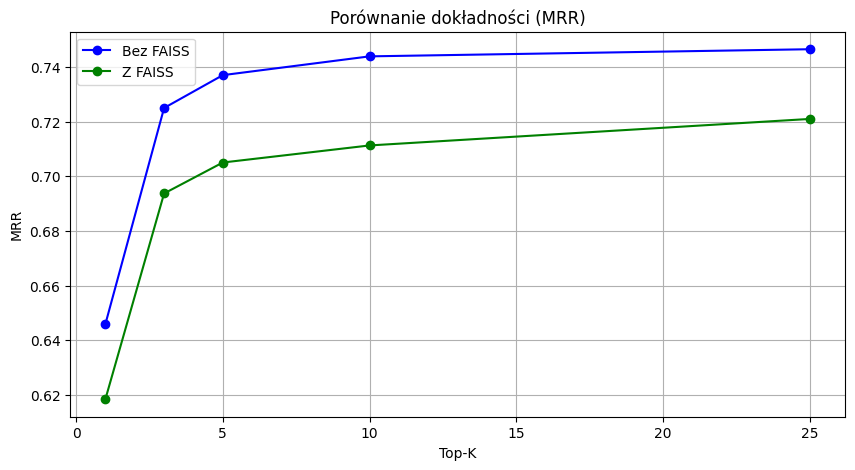

In [65]:
import matplotlib.pyplot as plt

# Wykres 1: Dokładność (MRR)
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, mrr, marker="o", label="Bez FAISS", color="blue")
plt.plot(topk_arr, mrr_with_faiss, marker="o", label="Z FAISS", color="green")
plt.title("Porównanie dokładności (MRR)")
plt.xlabel("Top-K")
plt.ylabel("MRR")
plt.grid(True)
plt.legend()
plt.show()

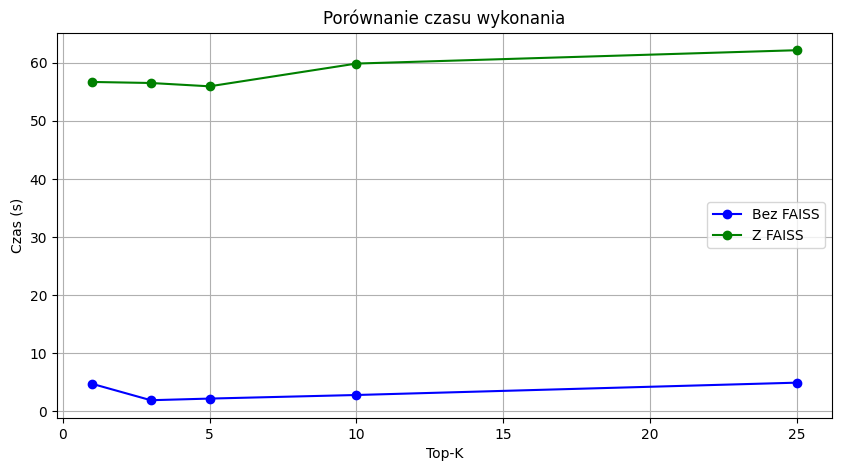

In [66]:
# Wykres 2: Czas wykonania
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, t, marker="o", label="Bez FAISS", color="blue")
plt.plot(topk_arr, t_with_faiss, marker="o", label="Z FAISS", color="green")
plt.title("Porównanie czasu wykonania")
plt.xlabel("Top-K")
plt.ylabel("Czas (s)")
plt.grid(True)
plt.legend()
plt.show()

## Analiza modelu re-ranker (cross-enkoder)

In [50]:
# Przygotowanie par (query, answer) do re-rankingu korzystając z all results

all_results_25 = find_similar_sentences(
    question_embeddings=question_embeddings,
    answer_embeddings=answer_embeddings,
    unique_questions=unique_questions,
    unique_answers=unique_answers,
    model=model,
    top_k=25,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
    n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
)


pairs = []
for query, answers in all_results_25.items():
    for answer in answers:
        pairs.append((query, answer["answer"]))

In [51]:
len(pairs)

2183525

In [52]:
from sentence_transformers import CrossEncoder

re_ranker = CrossEncoder("cross-encoder/ms-marco-TinyBERT-L-2-v2", device=device)

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [53]:
# Re-ranking za pomocą Cross-Encodera

scores = re_ranker.predict(
    pairs, batch_size=256, show_progress_bar=True, convert_to_tensor=True
)

Batches:   0%|          | 0/8530 [00:00<?, ?it/s]

In [ ]:
# with open('scores25.pkl', 'wb') as f:
#    pickle.dump(scores, f)
#
# with open('re_ranker25.pkl', 'wb') as f:
#    pickle.dump(re_ranker, f)

In [ ]:
import pickle

with open("scores25.pkl", "rb") as f:
    scores = pickle.load(f)

In [54]:
top_k = 25


def get_ranked_results(scores, pairs, top_k, unique_questions):

    # Tworzenie posortowanych wyników
    ranked_results = {}
    index = 0
    for query in unique_questions:
        ranked_results[query] = []
        for _ in range(top_k):
            if index < len(scores):
                ranked_results[query].append(
                    {"answer": pairs[index][1], "score": scores[index]}
                )
                index += 1
        ranked_results[query] = sorted(
            ranked_results[query], key=lambda x: x["score"], reverse=True
        )

    return ranked_results


rerank_results = get_ranked_results(scores, pairs, top_k, unique_questions)

In [55]:
# Wyświetlenie wyników przed i po re-rankingu
for query in list(all_results.keys())[15:20]:  # Wyświetl dla pierwszych 3 zapytań
    print(f"\nZapytanie: {query}")
    print("Przed re-rankiem:")
    for result in all_results[query][:5]:
        print(f"Score: {result['score']:.2f}, Answer: {result['answer']}")

    print("\nPo re-rankingu:")
    for result in rerank_results[query][:5]:
        print(f"Score: {result['score']:.2f}, Answer: {result['answer']}")


Zapytanie: What have the old converted cruiser aircraft carriers evolved into?
Przed re-rankiem:
Score: 0.65, Answer: Modern navies that operate such aircraft carriers treat them as the capital ship of the fleet, a role previously held by the battleship. This change took place during World War II in response to air power becoming a significant factor in warfare, driven by the superior range, flexibility and effectiveness of carrier-launched aircraft. Following the war, carrier operations continued to increase in size and importance. Supercarriers, displacing 75,000 tonnes or greater, have become the pinnacle of carrier development. Some are powered by nuclear reactors and form the core of a fleet designed to operate far from home. Amphibious assault ships, such as USS Tarawa and HMS Ocean, serve the purpose of carrying and landing Marines, and operate a large contingent of helicopters for that purpose. Also known as "commando carriers" or "helicopter carriers", many have the capabilit

In [61]:
avg_mrr = evaluate_results_with_mrr(
    all_results=rerank_results, true_relevance_dict=true_relevance_dict, top_k=5
)


Średnie MRR@5: 0.8072


In [62]:
import time

topk_arr = [1, 3, 5, 10]
mrr2 = []
mrr_with_rerank = []

for k in topk_arr:
    all_results_temp = find_similar_sentences(
        question_embeddings=question_embeddings,
        answer_embeddings=answer_embeddings,
        unique_questions=unique_questions,
        unique_answers=unique_answers,
        model=model,
        top_k=k,  # Liczba najbardziej podobnych odpowiedzi dla każdego zapytania
        n_print=0,  # Liczba zapytań do wyświetlenia w konsoli
    )

    avg_mrr = evaluate_results_with_mrr(
        all_results=all_results_temp,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    mrr2.append(avg_mrr)

    avg_mrr_with_rerank = evaluate_results_with_mrr(
        all_results=rerank_results,
        true_relevance_dict=true_relevance_dict,
        top_k=k,  # Liczba najlepszych wyników do uwzględnienia w ocenie
    )
    mrr_with_rerank.append(avg_mrr_with_rerank)


Średnie MRR@1: 0.6459

Średnie MRR@1: 0.7400

Średnie MRR@3: 0.7250

Średnie MRR@3: 0.7989

Średnie MRR@5: 0.7370

Średnie MRR@5: 0.8072

Średnie MRR@10: 0.7439

Średnie MRR@10: 0.8117


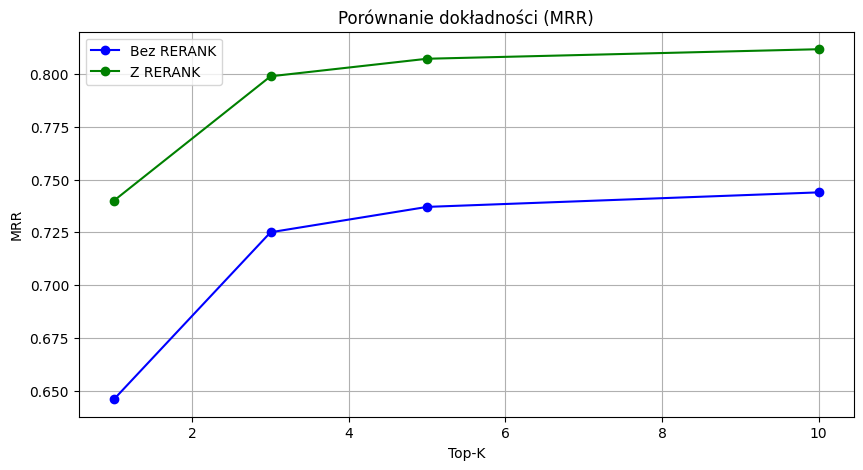

In [63]:
import matplotlib.pyplot as plt

# Wykres 1: Dokładność (NDCG)
plt.figure(figsize=(10, 5))
plt.plot(topk_arr, mrr2, marker="o", label="Bez RERANK", color="blue")
plt.plot(topk_arr, mrr_with_rerank, marker="o", label="Z RERANK", color="green")
plt.title("Porównanie dokładności (MRR)")
plt.xlabel("Top-K")
plt.ylabel("MRR")
plt.grid(True)
plt.legend()
plt.show()